# Playground

In [261]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *

In [262]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [263]:
constant_seed()

In [264]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load data

In [265]:
metadata_all = read_metadata("./data/all/metadata.csv")
mapping = get_MOA_mappings(metadata_all)

In [266]:
metadata = read_metadata("./data/tiny/metadata.csv")

In [267]:
metadata = shuffle_metadata(metadata)
metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

In [268]:
relative_path = get_relative_image_paths(metadata)
image_paths = ["./data/tiny/" + path for path in relative_path]
images = load_images(image_paths)

In [269]:
len(images)

259

## Normalize data

In [270]:
images = prepare_raw_images(images)
normalize_channels_inplace(images)
print(images.shape)

torch.Size([259, 3, 68, 68])


In [271]:
channel_first = view_channel_dim_first(images)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.02; 1.00]
channel 1 interval: [0.04; 1.00]
channel 2 interval: [0.05; 1.00]


## Prepare datasets

In [272]:
class SingleCellDataset(Dataset):
    
    def __init__(self, metadata: pd.DataFrame, images: torch.Tensor, label_to_id: Dict[str, int]):
        self.metadata = metadata
        self.label_to_id = label_to_id
        self.images = images
        
    def __len__(self):
        return self.metadata.shape[0]

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        image_id = row["Single_Cell_Image_Id"]
        image = self.images[image_id]
        
        label_name = row["moa"]
        label = self.label_to_id[label_name]
        
        return image, label

In [273]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)
test_set = SingleCellDataset(metadata_test, images, mapping)

## VAE

In [274]:
image_shape = np.array([3, 68, 68])
latent_features = 256

vae = CytoVariationalAutoencoder(image_shape, latent_features)
#vae = VariationalAutoencoder(image_shape, latent_features)
vae = vae.to(device)

beta = 1.
vi = VariationalInference(beta=beta)


num_epochs = 1000
batch_size = 32

learning_rate = 1e-3
weight_decay = 10e-4

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

In [275]:
training_data = defaultdict(list)
validation_data = defaultdict(list)

for epoch in range(num_epochs):
    print(f"epoch: {epoch}/{num_epochs}")    

    training_epoch_data = defaultdict(list)
    
    vae.train()

    for x, _ in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    print("training | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(training_epoch_data["elbo"]), np.mean(training_epoch_data["log_px"]), np.mean(training_epoch_data["kl"])))

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        for x, _ in validation_loader:
            x = x.to(device)
          
            loss, diagnostics, outputs = vi(vae, x)
            
            for k, v in diagnostics.items():
                training_epoch_data[k] += [np.mean(validation_epoch_data[k])]

        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]

    print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))    

epoch: 0/1000
training | elbo: -14773.777995, log_px: -13329.27, kl: 1444.51:


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


validation | elbo: -13052.117188, log_px: -13026.86, kl: 25.25:
epoch: 1/1000
training | elbo: -13554.753092, log_px: -12855.42, kl: 699.33:
validation | elbo: -13145.798340, log_px: -12952.49, kl: 193.31:
epoch: 2/1000
training | elbo: -13302.943848, log_px: -12808.43, kl: 494.51:
validation | elbo: -13480.408203, log_px: -12906.99, kl: 573.42:
epoch: 3/1000
training | elbo: -13224.511230, log_px: -12794.09, kl: 430.42:
validation | elbo: -13818.932129, log_px: -12879.81, kl: 939.12:
epoch: 4/1000
training | elbo: -13167.648763, log_px: -12781.14, kl: 386.50:
validation | elbo: -13979.445508, log_px: -12857.26, kl: 1122.18:
epoch: 5/1000
training | elbo: -13102.958659, log_px: -12772.44, kl: 330.52:
validation | elbo: -14009.654297, log_px: -12840.72, kl: 1168.93:
epoch: 6/1000
training | elbo: -13062.271322, log_px: -12759.85, kl: 302.42:
validation | elbo: -13964.570173, log_px: -12829.68, kl: 1134.89:
epoch: 7/1000
training | elbo: -13043.595540, log_px: -12744.89, kl: 298.71:
vali

training | elbo: -11842.447754, log_px: -11730.98, kl: 111.47:
validation | elbo: -12659.637910, log_px: -12408.70, kl: 250.94:
epoch: 59/1000
training | elbo: -11819.741536, log_px: -11693.51, kl: 126.23:
validation | elbo: -12644.735107, log_px: -12396.63, kl: 248.10:
epoch: 60/1000
training | elbo: -11770.212891, log_px: -11655.35, kl: 114.87:
validation | elbo: -12631.153673, log_px: -12384.33, kl: 246.82:
epoch: 61/1000
training | elbo: -11738.779460, log_px: -11618.18, kl: 120.60:
validation | elbo: -12617.652107, log_px: -12371.85, kl: 245.80:
epoch: 62/1000
training | elbo: -11700.887858, log_px: -11577.64, kl: 123.24:
validation | elbo: -12602.557276, log_px: -12358.84, kl: 243.72:
epoch: 63/1000
training | elbo: -11646.879720, log_px: -11534.50, kl: 112.38:
validation | elbo: -12586.807465, log_px: -12345.71, kl: 241.10:
epoch: 64/1000
training | elbo: -11597.695150, log_px: -11492.69, kl: 105.01:
validation | elbo: -12570.654192, log_px: -12332.31, kl: 238.34:
epoch: 65/1000

training | elbo: -8002.495850, log_px: -7938.56, kl: 63.94:
validation | elbo: -11392.971826, log_px: -11233.51, kl: 159.46:
epoch: 117/1000
training | elbo: -7913.549235, log_px: -7841.23, kl: 72.31:
validation | elbo: -11363.186403, log_px: -11204.49, kl: 158.70:
epoch: 118/1000
training | elbo: -7822.165609, log_px: -7747.35, kl: 74.81:
validation | elbo: -11333.136834, log_px: -11175.25, kl: 157.88:
epoch: 119/1000
training | elbo: -7720.324707, log_px: -7648.16, kl: 72.16:
validation | elbo: -11302.439412, log_px: -11145.42, kl: 157.02:
epoch: 120/1000
training | elbo: -7629.213623, log_px: -7550.42, kl: 78.79:
validation | elbo: -11271.336950, log_px: -11115.10, kl: 156.23:
epoch: 121/1000
training | elbo: -7520.343587, log_px: -7454.17, kl: 66.18:
validation | elbo: -11239.598177, log_px: -11084.23, kl: 155.37:
epoch: 122/1000
training | elbo: -7431.631104, log_px: -7357.10, kl: 74.53:
validation | elbo: -11207.265800, log_px: -11052.72, kl: 154.55:
epoch: 123/1000
training | el

validation | elbo: -9151.752765, log_px: -9032.24, kl: 119.52:
epoch: 175/1000
training | elbo: -1277.959412, log_px: -1224.83, kl: 53.12:
validation | elbo: -9106.408864, log_px: -8987.39, kl: 119.02:
epoch: 176/1000
training | elbo: -1177.469116, log_px: -1117.84, kl: 59.63:
validation | elbo: -9061.017996, log_px: -8942.49, kl: 118.53:
epoch: 177/1000
training | elbo: -1081.901245, log_px: -1028.37, kl: 53.53:
validation | elbo: -9015.441023, log_px: -8897.39, kl: 118.05:
epoch: 178/1000
training | elbo: -1006.649445, log_px: -950.83, kl: 55.82:
validation | elbo: -8970.157374, log_px: -8852.59, kl: 117.56:
epoch: 179/1000
training | elbo: -878.340027, log_px: -825.23, kl: 53.11:
validation | elbo: -8924.182383, log_px: -8807.10, kl: 117.09:
epoch: 180/1000
training | elbo: -806.753906, log_px: -752.16, kl: 54.59:
validation | elbo: -8878.814008, log_px: -8762.19, kl: 116.63:
epoch: 181/1000
training | elbo: -734.208486, log_px: -681.47, kl: 52.74:
validation | elbo: -8833.889209, l

validation | elbo: -6429.672993, log_px: -6330.23, kl: 99.44:
epoch: 235/1000
training | elbo: 3953.692505, log_px: 4011.68, kl: 57.99:
validation | elbo: -6385.781348, log_px: -6286.59, kl: 99.19:
epoch: 236/1000
training | elbo: 4030.981242, log_px: 4089.93, kl: 58.95:
validation | elbo: -6341.537115, log_px: -6242.59, kl: 98.95:
epoch: 237/1000
training | elbo: 4093.866496, log_px: 4152.56, kl: 58.69:
validation | elbo: -6297.722118, log_px: -6199.03, kl: 98.70:
epoch: 238/1000
training | elbo: 4139.608724, log_px: 4196.72, kl: 57.11:
validation | elbo: -6254.008302, log_px: -6155.56, kl: 98.45:
epoch: 239/1000
training | elbo: 4191.307699, log_px: 4248.32, kl: 57.01:
validation | elbo: -6210.392030, log_px: -6112.21, kl: 98.19:
epoch: 240/1000
training | elbo: 4272.590332, log_px: 4326.30, kl: 53.71:
validation | elbo: -6166.753577, log_px: -6068.82, kl: 97.93:
epoch: 241/1000
training | elbo: 4328.073079, log_px: 4387.84, kl: 59.77:
validation | elbo: -6123.262241, log_px: -6025.5

training | elbo: 7145.944499, log_px: 7208.96, kl: 63.01:
validation | elbo: -3940.053702, log_px: -3851.94, kl: 88.11:
epoch: 296/1000
training | elbo: 7136.654704, log_px: 7198.65, kl: 62.00:
validation | elbo: -3903.244331, log_px: -3815.25, kl: 88.00:
epoch: 297/1000
training | elbo: 7181.972168, log_px: 7244.75, kl: 62.77:
validation | elbo: -3865.869433, log_px: -3778.01, kl: 87.86:
epoch: 298/1000
training | elbo: 7238.259928, log_px: 7300.34, kl: 62.09:
validation | elbo: -3828.532375, log_px: -3740.78, kl: 87.75:
epoch: 299/1000
training | elbo: 7303.303223, log_px: 7365.23, kl: 61.93:
validation | elbo: -3791.328326, log_px: -3703.72, kl: 87.61:
epoch: 300/1000
training | elbo: 7402.977376, log_px: 7469.27, kl: 66.29:
validation | elbo: -3754.126333, log_px: -3666.64, kl: 87.49:
epoch: 301/1000
training | elbo: 7338.744385, log_px: 7401.73, kl: 62.98:
validation | elbo: -3717.274541, log_px: -3629.92, kl: 87.35:
epoch: 302/1000
training | elbo: 7458.434570, log_px: 7521.46, k

validation | elbo: -1859.886640, log_px: -1777.66, kl: 82.22:
epoch: 356/1000
training | elbo: 9634.215169, log_px: 9704.75, kl: 70.54:
validation | elbo: -1827.690964, log_px: -1745.54, kl: 82.15:
epoch: 357/1000
training | elbo: 9675.435059, log_px: 9745.66, kl: 70.23:
validation | elbo: -1795.580537, log_px: -1713.51, kl: 82.07:
epoch: 358/1000
training | elbo: 9810.302246, log_px: 9882.24, kl: 71.94:
validation | elbo: -1763.101724, log_px: -1681.11, kl: 82.00:
epoch: 359/1000
training | elbo: 9910.223958, log_px: 9981.69, kl: 71.47:
validation | elbo: -1730.801604, log_px: -1648.89, kl: 81.91:
epoch: 360/1000
training | elbo: 9990.722982, log_px: 10063.54, kl: 72.82:
validation | elbo: -1698.723866, log_px: -1616.89, kl: 81.84:
epoch: 361/1000
training | elbo: 10015.833008, log_px: 10087.88, kl: 72.04:
validation | elbo: -1666.688097, log_px: -1584.92, kl: 81.77:
epoch: 362/1000
training | elbo: 10071.255859, log_px: 10143.31, kl: 72.06:
validation | elbo: -1634.778098, log_px: -1

validation | elbo: -37.682385, log_px: 41.42, kl: 79.11:
epoch: 416/1000
training | elbo: 11786.137044, log_px: 11866.14, kl: 80.00:
validation | elbo: -9.176801, log_px: 69.90, kl: 79.08:
epoch: 417/1000
training | elbo: 12004.802083, log_px: 12085.37, kl: 80.57:
validation | elbo: 19.285406, log_px: 98.33, kl: 79.05:
epoch: 418/1000
training | elbo: 12023.076335, log_px: 12106.84, kl: 83.76:
validation | elbo: 47.736577, log_px: 126.74, kl: 79.01:
epoch: 419/1000
training | elbo: 12059.440430, log_px: 12141.49, kl: 82.04:
validation | elbo: 75.937567, log_px: 154.91, kl: 78.97:
epoch: 420/1000
training | elbo: 11847.440918, log_px: 11931.44, kl: 84.00:
validation | elbo: 103.563508, log_px: 182.50, kl: 78.94:
epoch: 421/1000
training | elbo: 11752.746419, log_px: 11836.57, kl: 83.83:
validation | elbo: 131.350837, log_px: 210.28, kl: 78.93:
epoch: 422/1000
training | elbo: 11907.236165, log_px: 11989.75, kl: 82.51:
validation | elbo: 159.290636, log_px: 238.20, kl: 78.91:
epoch: 423/

validation | elbo: 1587.020685, log_px: 1665.04, kl: 78.02:
epoch: 477/1000
training | elbo: 13929.367350, log_px: 14021.35, kl: 91.98:
validation | elbo: 1612.288294, log_px: 1690.31, kl: 78.02:
epoch: 478/1000
training | elbo: 13836.002441, log_px: 13927.97, kl: 91.97:
validation | elbo: 1636.201024, log_px: 1714.22, kl: 78.02:
epoch: 479/1000
training | elbo: 13265.976400, log_px: 13359.53, kl: 93.55:
validation | elbo: 1661.241876, log_px: 1739.26, kl: 78.02:
epoch: 480/1000
training | elbo: 13785.509277, log_px: 13878.07, kl: 92.56:
validation | elbo: 1686.103781, log_px: 1764.12, kl: 78.02:
epoch: 481/1000
training | elbo: 13814.002930, log_px: 13905.38, kl: 91.37:
validation | elbo: 1711.133845, log_px: 1789.15, kl: 78.02:
epoch: 482/1000
training | elbo: 13938.043457, log_px: 14029.13, kl: 91.09:
validation | elbo: 1736.028631, log_px: 1814.03, kl: 78.01:
epoch: 483/1000
training | elbo: 13898.719076, log_px: 13991.50, kl: 92.78:
validation | elbo: 1760.878647, log_px: 1838.88,

training | elbo: 15699.282227, log_px: 15802.03, kl: 102.75:
validation | elbo: 3045.114199, log_px: 3123.50, kl: 78.39:
epoch: 538/1000
training | elbo: 15799.842122, log_px: 15902.46, kl: 102.62:
validation | elbo: 3068.011631, log_px: 3146.42, kl: 78.41:
epoch: 539/1000
training | elbo: 15827.488118, log_px: 15931.86, kl: 104.37:
validation | elbo: 3091.118695, log_px: 3169.55, kl: 78.43:
epoch: 540/1000
training | elbo: 15718.165690, log_px: 15822.85, kl: 104.68:
validation | elbo: 3113.597315, log_px: 3192.05, kl: 78.45:
epoch: 541/1000
training | elbo: 15670.734701, log_px: 15776.16, kl: 105.42:
validation | elbo: 3136.545392, log_px: 3215.01, kl: 78.47:
epoch: 542/1000
training | elbo: 15819.429036, log_px: 15924.47, kl: 105.04:
validation | elbo: 3159.136218, log_px: 3237.62, kl: 78.49:
epoch: 543/1000
training | elbo: 15884.652018, log_px: 15990.94, kl: 106.29:
validation | elbo: 3182.128638, log_px: 3260.63, kl: 78.51:
epoch: 544/1000
training | elbo: 15950.488932, log_px: 16

KeyboardInterrupt: 

In [276]:
def plot_VAE_performance(elbo, log_px, kl):
    fig, axs = plt.subplots(1, 3, figsize=(14,6), constrained_layout = True)
    fig.suptitle("VAE - learning", fontsize=16)
    
    ax1 = axs[0]
    ax1.grid()
    ax1.plot(log_px)
    ax1.set_ylabel("elbo")
    ax1.set_xlabel("epoch")
    
    ax2 = axs[1]
    ax2.grid()
    ax2.plot(log_px)
    ax2.set_ylabel("log p(x)")
    ax2.set_xlabel("epoch")
    
    ax3 = axs[2]
    ax3.grid()
    ax3.plot(kl)
    ax3.set_ylabel("KL-divergence")
    ax3.set_xlabel("epoch")

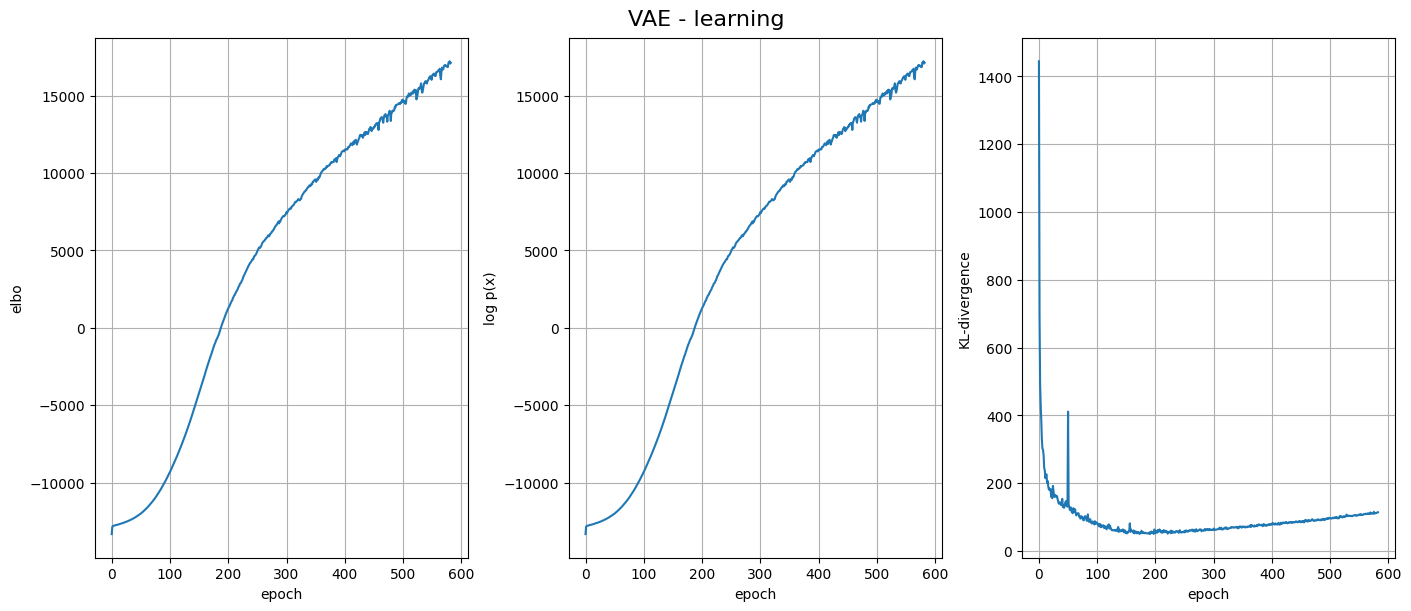

In [277]:
plot_VAE_performance(**training_data)

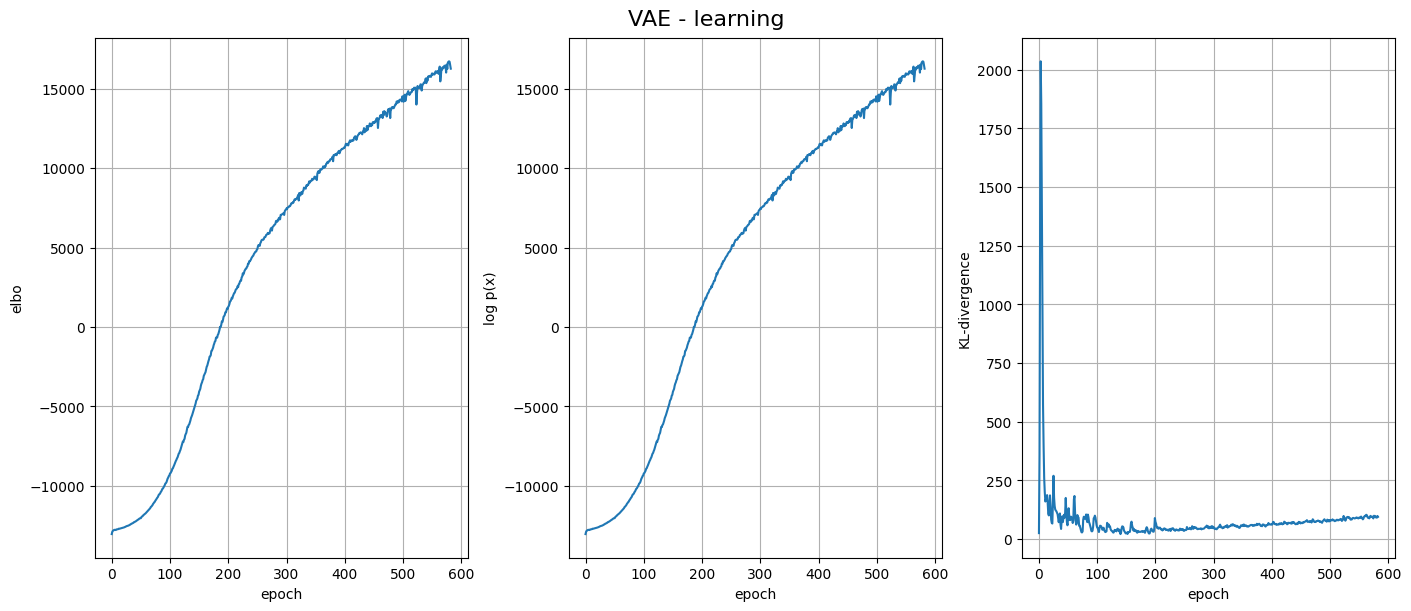

In [278]:
plot_VAE_performance(**validation_data)

## Compare reconstruction and original image

In [293]:
x, _ = validation_set[12]

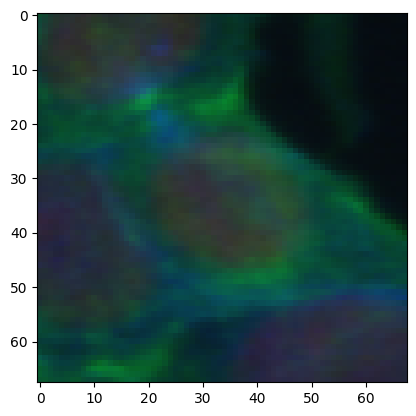

In [294]:
plot_image(x)

In [295]:
vae.eval() # because of batch normalization
outputs = vae(x[None,:,:,:])
px = outputs["px"]

x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]

In [296]:
# @TODO cleanup. Used to images from cluster quickly
#x_reconstruction = torch.tensor(np.array(load_images(["./dump/images/x0_reconstruction.npy"])[0], dtype=np.float32))
#x = torch.tensor(np.array(load_images(["./dump/images/x0.npy"])[0], dtype=np.float32))

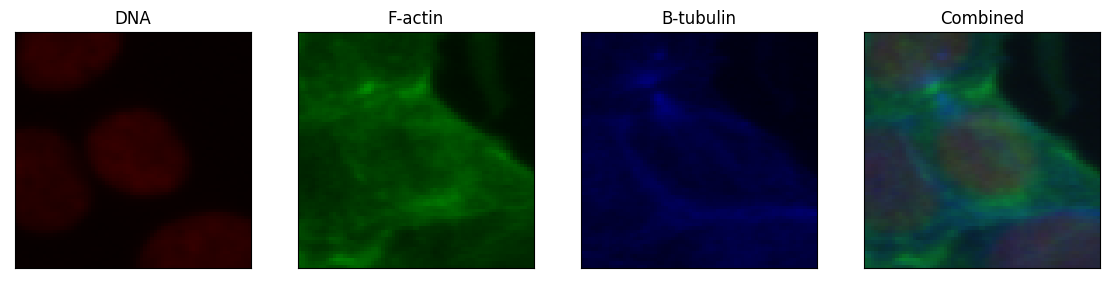

In [297]:
plot_image_channels(x)

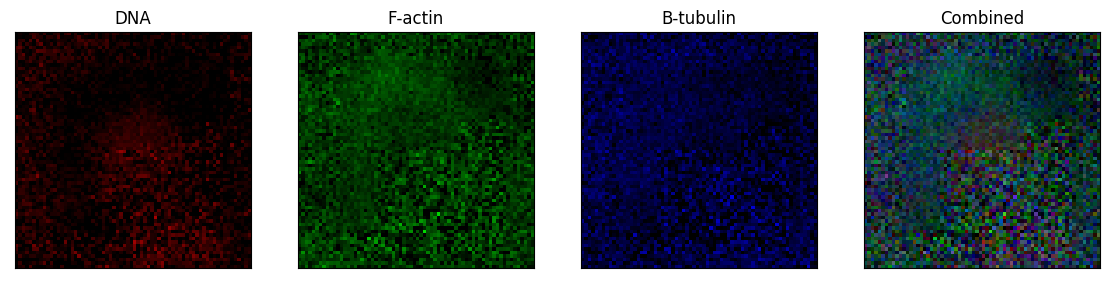

In [298]:
plot_image_channels(x_reconstruction)

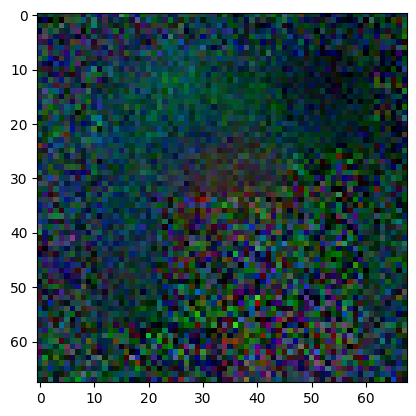

In [299]:
plot_image(clip_image_to_zero_one(x_reconstruction))

## Downstream Classification

In [300]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, n_classes: int = 13):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes))

    def forward(self, x):
        logits = self.net(x)
        return logits

    
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)
print(classifier)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [301]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features) # @TODO: load trained parameters
vae.eval()

# Classifier
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)

# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2)

num_epochs = 10
batch_size = 32

In [302]:
def count_num_correct(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()

In [303]:
train_loss = []
train_accuracy = []

validation_loss = []
validation_accuracy = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}/{num_epochs}")    

    train_epoch_loss = []
    train_epoch_accuracy = []
    
    classifier.train()
    
    train_correct = 0
    train_num_predictions = 0
    
    for x, y in train_loader:
        x = x.to(device)
        
        outputs = vae(x)
        z = outputs["z"]
        
        prediction_prob = classifier(z)
        loss = loss_fn(prediction_prob, y)
        
        train_epoch_loss.append(loss.item())
        
        N = len(x)
        train_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        train_correct += count_num_correct(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_mean_loss = np.mean(train_epoch_loss)
    train_loss.append(epoch_mean_loss)
    train_accuracy.append(train_correct / train_num_predictions)
    
    print("training | loss: {:.2f}".format(epoch_mean_loss))
    
    
    validation_epoch_loss = []
    classifier.eval()
    
    validation_correct = 0
    validation_num_predictions = 0
    
    for x, y in validation_loader:
        x = x.to(device)
        
        outputs = vae(x)
        z = outputs["z"]
        
        prediction_prob = classifier(z)
        loss = loss_fn(prediction_prob, y)
        
        validation_epoch_loss.append(loss.item())
        
        N = len(x)
        validation_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        validation_correct += count_num_correct(pred, y)

    epoch_mean_loss = np.mean(validation_epoch_loss)
    validation_loss.append(epoch_mean_loss)
    validation_accuracy.append(validation_correct / validation_num_predictions)
   
        
    print("validation | loss: {:.2f}".format(epoch_mean_loss))

epoch: 0/10
training | loss: 2.51
validation | loss: 2.42
epoch: 1/10
training | loss: 2.36
validation | loss: 2.27
epoch: 2/10
training | loss: 2.21
validation | loss: 2.12
epoch: 3/10
training | loss: 2.05
validation | loss: 1.93
epoch: 4/10
training | loss: 1.87
validation | loss: 1.75
epoch: 5/10
training | loss: 1.66
validation | loss: 1.57
epoch: 6/10
training | loss: 1.46
validation | loss: 1.30
epoch: 7/10
training | loss: 1.24
validation | loss: 1.08
epoch: 8/10
training | loss: 1.00
validation | loss: 0.87
epoch: 9/10
training | loss: 0.77
validation | loss: 0.66


In [304]:
def plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy):
    fig, axs = plt.subplots(1, 2, figsize=(14,6), constrained_layout = True)
    fig.suptitle("Classifier - learning", fontsize=16)

    ax1 = axs[0]
    ax1.grid()
    ax1.plot(train_loss)
    ax1.plot(validation_loss)
    ax1.legend(["train", "validation"])
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")

    ax2 = axs[1]
    ax2.grid()
    ax2.plot(train_accuracy)
    ax2.plot(validation_accuracy)
    ax2.legend(["train", "validation"])
    ax2.set_ylabel("accuracy")
    ax2.set_xlabel("epoch")

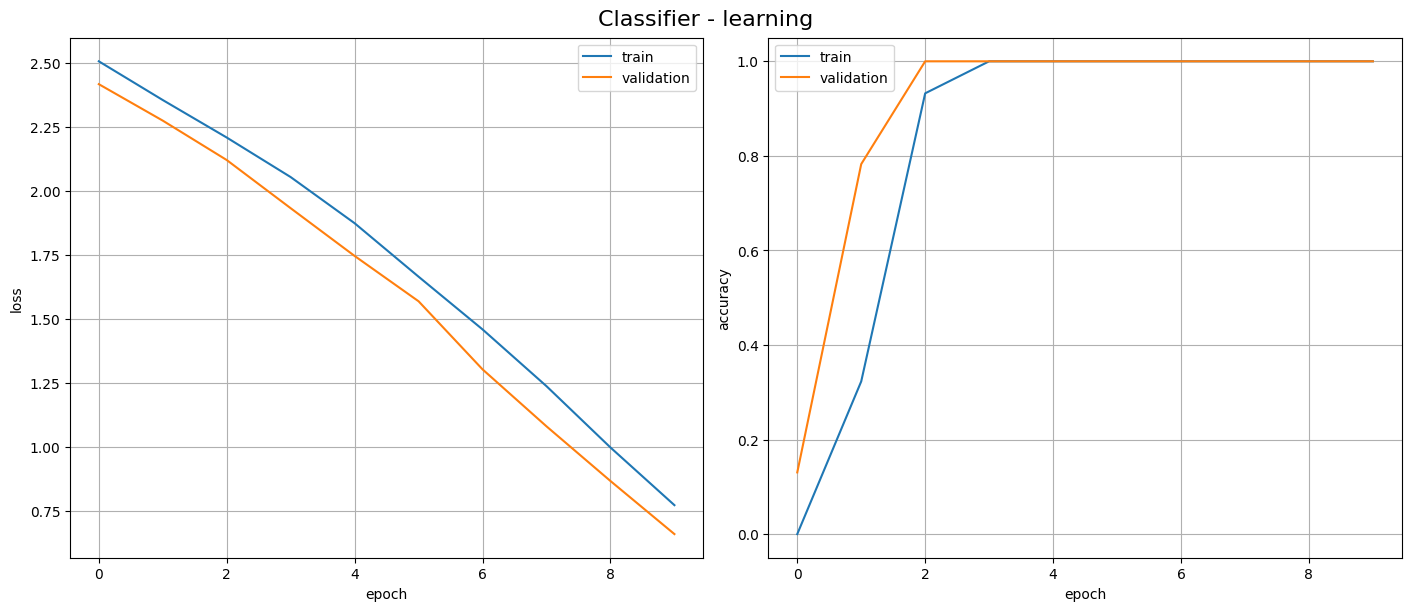

In [305]:
plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy)

## @TODO
- Look at latent representation
    - How does changing one latent variable change the image reconstruction?
    - How similiar are images in the latent space (cosine-simularity)